In [50]:
import numpy as np
from scipy.sparse import spdiags
from scipy.sparse import bmat
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

### Problem #1

In [41]:
def poisson_square(a1,b1,c1,d1,n,bcs, source):
    # n = number of subintervals
    # We discretize in the x dimension by
    # a1 = x_0 < x_1< ... < x_n=b1, and
    # We discretize in the y dimension by
    # c1 = y_0 < y_1< ... < y_n=d1.
    # This means that we have interior points
    # {x_1, ..., x_{n-1}}\times {y_1, ..., y_{n-1}}
    # or {x_1, ..., x_m}\times {y_1, ..., y_m} where m = n-1.
    # In Python, this is indexed as
    # {x_0, ..., x_{m-1}}\times {y_0, ..., y_{m-1}}
    # We will have m**2 pairs of interior points, and
    # m**2 corresponding equations.
    # We will organize these equations by their
    # y coordinates: all equations centered
    # at (x_i, y_0) will be listed first,
    # then (x_i, y_1), and so on till (x_i, y_{m-1})
    delta_x, delta_y, h, m = (b1-a1)/n, (d1-c1)/n, (b1-a1)/n, n-1
    ####    Construct the matrix A    ####
    ones = np.ones(n-1)
    diags = [-4*ones,ones,ones]
    off = [0,-1,1]
    T = spdiags(diags,off,n-1,n-1)
    I = spdiags(ones,[0],n-1,n-1)
    A = bmat([[T if i==j else I if abs(i-j)==1 else None for i in range(n-1)] for j in range(n-1)],format='bsr')
    A = csr_matrix(A)
    if n <= 5 :
        print(A.toarray())
    ####    Here we construct the vector b=f-p-q    ####
    b, Array = np.zeros(m**2), np.linspace(0.,1.,m+2)[1:-1]
    # In the next line, source represents
    # the inhomogenous part of Poisson's equation
    for j in range(m):
        b[j*m:(j+1)*m] = source(a1+(b1-a1)*Array, c1+(j+1)*h*np.ones(m) )
    # In the next four lines, bcs represents the
    # Dirichlet conditions on the boundary
    # y = c1+h, d1-h
    b[0:m] -= h**(-2.)*bcs(a1+(b1-a1)*Array,c1*np.ones(m))
    b[(m-1)*m:m**2] -= h**(-2.)*bcs(a1+(b1-a1)*Array,d1*np.ones(m))
    # x = a1+h, b1-h
    b[0::m] -= h**(-2.)*bcs(a1*np.ones(m),c1+(d1-c1)*Array)
    b[(m-1)::m] -= h**(-2.)*bcs(b1*np.ones(m),c1+(d1-c1)*Array)
    ####    Here we solve the system A*soln = b    ####
    soln = spsolve(A,h**2*b)
    # We return the solution, and the boundary values,
    # in the array z.
    z = np.zeros((m+2,m+2) )
    for j in range(m):
        z[1:-1,j+1] = soln[j*m:(j+1)*m]
    x, y = np.linspace(a1,b1,m+2), np.linspace(c1,d1,m+2)
    z[:,0], z[:,m+1]  = bcs(x,c1*np.ones(len(x)) ), bcs(x,d1*np.ones(len(x)) )
    z[0,:], z[m+1,:] = bcs(a1*np.ones(len(x)),y), bcs(b1*np.ones(len(x)),y)
    return z

In [42]:
a,c = 0,0
b,d = 1,1
f = lambda x,y : np.zeros_like(x)
h = lambda x,y : x**3
n = 100
z = poisson_square(a,b,c,d,n,h,f)

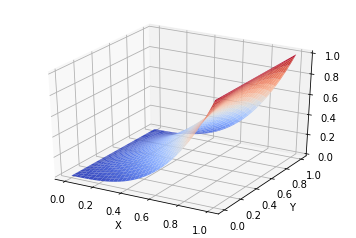

In [49]:
x,y = np.linspace(a,b,n+1), np.linspace(c,d,n+1)
X,Y = np.meshgrid(x,y)
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
surf = ax.plot_surface(Y,X,z,cmap='coolwarm')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

### Problem #2

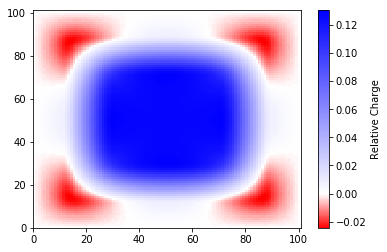

In [53]:
def source(X,Y):
    """
Takes arbitrary arrays of coordinates X and Y and returns an array of the ←  same shape
    representing the charge density of nested charged squares
    """
    src = np.zeros(X.shape)
    src[ np.logical_or(
        np.logical_and( np.logical_or(abs(X-1.5) < .1,abs(X+1.5) < .1) ,abs(Y) < 1.6),
        np.logical_and( np.logical_or(abs(Y-1.5) < .1,abs(Y+1.5) < .1) ,abs(X) < 1.6))] = 1
    src[ np.logical_or(
        np.logical_and( np.logical_or(abs(X-0.9) < .1,abs(X+0.9) < .1) ,abs(Y) < 1.0),
        np.logical_and( np.logical_or(abs(Y-0.9) < .1,abs(Y+0.9) < .1) ,abs(X) < 1.0))] = -1
    return src

#Generate a color dictionary for use with LinearSegmentedColormap
#that places red and blue at the min and max values of data
#and white when data is zero
def genDict(data):
    zero = 1/(1 - np.max(data)/np.min(data))
    cdict = {'red':   [(0.0,  1.0, 1.0),
                   (zero,  1.0, 1.0),
                   (1.0,  0.0, 0.0)],
         'green': [(0.0,  0.0, 0.0),
                   (zero,  1.0, 1.0),
                   (1.0,  0.0, 0.0)],
         'blue':  [(0.0,  0.0, 0.0),
                   (zero,  1.0, 1.0),
                   (1.0,  1.0, 1.0)]}
    return cdict

a1 = -2.
b1 = 2.
c1 = -2.
d1 = 2.
n =100
z = poisson_square(a1,b1,c1,d1,n,f,source)
X = np.linspace(a1,b1,n)
Y = np.linspace(c1,d1,n)
X,Y = np.meshgrid(X,Y)
plt.pcolormesh(z,cmap = mcolors.LinearSegmentedColormap('cmap', genDict(z)))
plt.colorbar(label="Relative Charge")
plt.show()